# Tutorial Code Execution

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

train_losses = []
val_losses = []

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    total_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        total_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    train_losses.append(total_loss / len(dataloader))

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    val_losses.append(test_loss)

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)
Epoch 1
-------------------------------
loss: 2.293637  [   64/60000]
loss: 2.285753  [ 6464/60000]
loss: 2.268361  [12864/60000]
loss: 2.270141  [19264/60000]
loss: 2.252977  [25664/60000]
loss: 2.216660  [32064/60000]
loss: 2.233387  [38464/60000]
loss: 2.188181  [44864/60000]
loss: 2.182507  [51264/60000]
loss: 2.163496  [57664/60000]
Test Error: 
 Accuracy: 40.6%, Avg loss: 2.152200 

Epoch 2
-------------------------------
loss: 2.154418  [   64/60000]
loss: 2.150370  [ 6464/60000]
loss: 2.092145  [12864/60000]
loss: 2.108547  [19264/60000]
loss: 2.070583  [2

# Loadind and Testing

In [4]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


# Validation Loss Curve

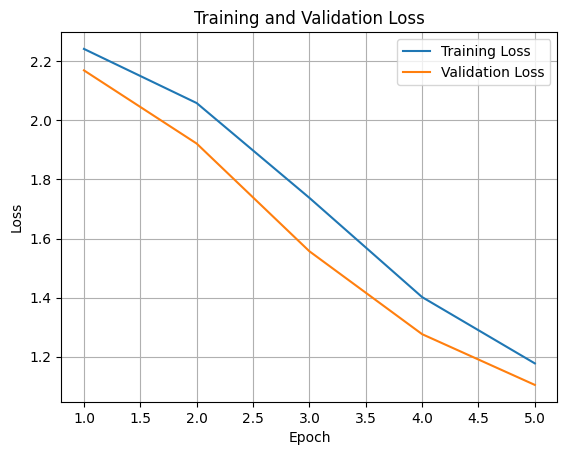

In [4]:
import matplotlib.pyplot as plt

plt.plot(range(1, epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Changing Loss Function

100%|██████████| 26.4M/26.4M [00:01<00:00, 16.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 264kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.04MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 7.88MB/s]


Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)
Epoch 1
-------------------------------
loss: 1.859129  [   64/60000]
loss: 1.837911  [ 6464/60000]
loss: 1.818924  [12864/60000]
loss: 1.817432  [19264/60000]
loss: 1.771482  [25664/60000]
loss: 1.729792  [32064/60000]
loss: 1.742346  [38464/60000]
loss: 1.689185  [44864/60000]
loss: 1.679113  [51264/60000]
loss: 1.631511  [57664/60000]
Test Error: 
 Accuracy: 48.8%, Avg loss: 1.618499 

Epoch 2
-------------------------------
loss: 1.627724  [   64/60000]
loss: 1.606553  [ 6464/60000]
loss: 1.516751  [12864/60000]
loss: 1.547892  [19264/60000]
loss: 1.439491  [2

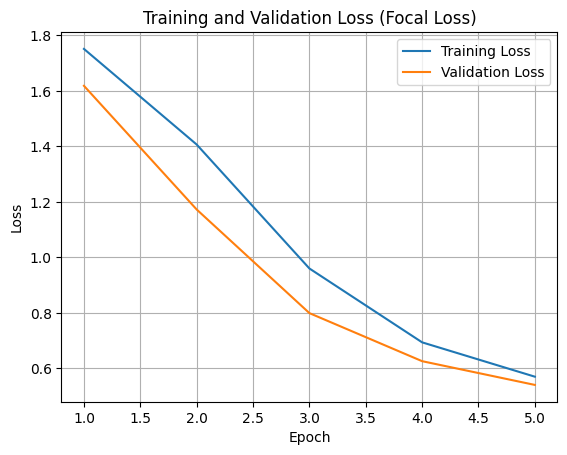

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
    root="data", train=True, download=True, transform=ToTensor()
)
test_data = datasets.FashionMNIST(
    root="data", train=False, download=True, transform=ToTensor()
)

batch_size = 64

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=1.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = nn.functional.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss.sum()

loss_fn = FocalLoss(gamma=2.0)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

train_losses = []
val_losses = []

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    total_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss_item, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss_item:>7f}  [{current:>5d}/{size:>5d}]")

    train_losses.append(total_loss / len(dataloader))

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)
            test_loss += loss.item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    val_losses.append(test_loss)
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

torch.save(model.state_dict(), "model_focal_loss.pth")
print("Saved PyTorch Model State to model_focal_loss.pth")

plt.plot(range(1, epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss (Focal Loss)")
plt.legend()
plt.grid(True)
plt.show()

# Observations

I employed Focal Loss since it's specifically designed to deal with class imbalance and improve learning on hard to classify examples by down weighting easy examples and paying closer attention to the harder ones. I observed notable differences in the models performance after modifying the loss function. Cross Entropy Loss being the default for multi-class classification kept on improving with every epoch and the model had an accuracy of 64.6% and a validation loss of 1.1040 at the fifth epoch. However I observed a significant performance boost after switching to Focal Loss. The model not only started with a higher initial accuracy of 48.8% in the first epoch but also achieved a final accuracy of 67.8%, outperforming the baseline. In addition to this, validation loss dropped more significantly to 0.5404, a sign that Focal Loss helped the model focus more on difficult-to-classify examples and converge faster. This clearly showed that the use of Focal Loss improved the model's learning dynamics and generalization performance.

# Creating a CNN with 3 x 3 Filter

Using cpu device
PooledCNN(
  (conv): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=1352, out_features=10, bias=True)
)

Epoch 1
Train loss: 0.8093
Test Accuracy: 74.78%, Validation loss: 0.6597

Epoch 2
Train loss: 0.5486
Test Accuracy: 76.06%, Validation loss: 0.6226

Epoch 3
Train loss: 0.5021
Test Accuracy: 77.75%, Validation loss: 0.5832

Epoch 4
Train loss: 0.4739
Test Accuracy: 79.42%, Validation loss: 0.5461

Epoch 5
Train loss: 0.4536
Test Accuracy: 80.38%, Validation loss: 0.5181

Saved model to cnn_model.pth


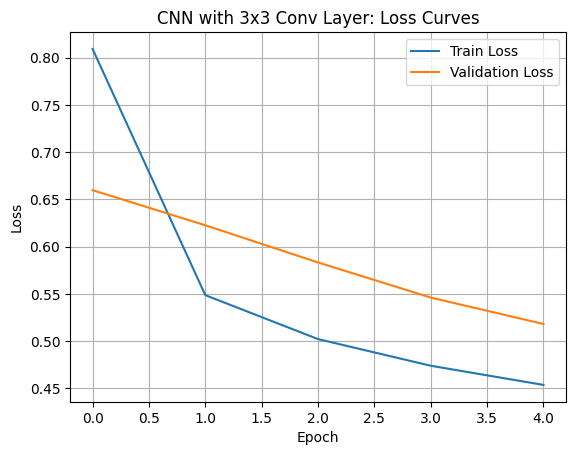

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

batch_size = 64
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class PooledCNN(nn.Module):
    def __init__(self):
        super(PooledCNN, self).__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(8 * 13 * 13, 10)

    def forward(self, x):
        x = torch.relu(self.conv(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

model = PooledCNN().to(device)
print(model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

train_losses, val_losses = [], []

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    total_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    train_losses.append(avg_loss)
    print(f"Train loss: {avg_loss:.4f}")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    avg_loss = test_loss / len(dataloader)
    val_losses.append(avg_loss)
    accuracy = correct / size
    print(f"Test Accuracy: {(100*accuracy):.2f}%, Validation loss: {avg_loss:.4f}")

epochs = 5
for t in range(epochs):
    print(f"\nEpoch {t+1}")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)

torch.save(model.state_dict(), "cnn_model.pth")
print("\nSaved model to cnn_model.pth")

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CNN with 3x3 Conv Layer: Loss Curves")
plt.legend()
plt.grid(True)
plt.show()

# Observations

The model using the CNN layer showed promising outcomes with improved training loss and test accuracy through the epochs. For instance, upon the completion of the first epoch, the model had an accuracy of 74.78% on tests and a loss of 0.6597 in validation, whereas at epoch five, there was a test accuracy of 80.38% and validation loss of 0.5181. On the other hand, the DNN model in the tutorial which was composed of fully connected layers exhibited slower convergence and performance. Training in the DNN was slower to achieve the same levels of accuracy and the absence of spatial hierarchies in the architecture was likely the cause of this slower learning rate. But the CNN, with its convolutional layer, has the benefit of being able to capture local image patterns, leading to better learning and better performance in accuracy and generalization.

The primary benefit of using a CNN is that it can identify and learn spatial features such as edges and textures that are significant in image recognition tasks. This enables the CNN to surpass the DNN, which is not spatially aware due to being completely connected. Thus, the CNN outperforms the DNN in both training efficiency and final accuracy on the FashionMNIST dataset, highlighting the strength of convolutional architectures for image classification tasks.